# Data Organization for linArray_app

In [1]:
#load libraries
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import math
import alignment_functions as af
import PyTrack.etDataReader as et

In [ ]:
#dir( af )

In [2]:
from os import listdir
from os.path import isfile, join
mypath = "/home/bonzilla/Documents/ScienceLife/linArray/linArray_data/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print( onlyfiles )

['T35_083018_t1_spikingDAT.mat', 'T35_083018_t2_spikingDAT.mat', 'T35_083018_t2-01.plx', 'T35_083018_t2.plx', 'T35_083018_t3.plx', 'T35_083018_t1.plx', 'T35_083018_t3_spikingDAT.mat', 'T35_083018_t1-01.plx']


In [5]:
#load .mat into python environment @ new machine
chosen_data = onlyfiles[0]
linArrayPath = mypath + chosen_data
linArrayMat = loadmat( linArrayPath )
multi_dSacctrials = af.getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals' )
multi_dSacctrials.shape

(14, 18)

In [8]:
multi_dSacctrials = af.getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals', timeint = [0., 90.] )
addStrobes = multi_dSacctrials.copy()
addStrobes = af.addEventMarker( linArrayMat, addStrobes, [ 30, 40, 555, 666, 100 ], 'delayedSaccIntervals' )

In [9]:
# aligning neural data
stimOn = 555 #define the eventmarker for stimulus onset
multi_DSalign = af.addStimOnset( addStrobes, stimOn, 'SPK' )

In [10]:
stimOnCols = af.getDataTypeNames( multi_DSalign, 'stimOn_' ).values.tolist()
stimOnCols = [item for sublist in stimOnCols for item in sublist]
time_axis_limits_ms = [ -50, 150 ]

In [18]:
#load behavioral .mat into python environment
path = "/home/bonzilla/Documents/ScienceLife/linArray/bhv_083018/"

bhv_file = "180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1).mat"
bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1).mat" #holds 22 trials, 14 correct trials Track2 RF mapping == T35_083018_t2_delayedSaccade.pkl
#bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(2).mat" #holds 52 trials, 41 correct trials Track2 RF+180
#bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(3).mat" #holds 82 trials, 70 correct trials ???
#bhvPath = path + "180830_Peanut_delayedSaccadeTask_2016_6_8(1).mat" #holds 152 trials, 64 correct trials Track1?
bhvMat = loadmat( bhvPath )

In [19]:
BHV_df = af.bhvmat2pandasdf( bhvMat )
BHV_plusEV = af.addMultiEventVariables( BHV_df, [ 30, 40, 666, 100 ] )
print( BHV_plusEV.shape )
# select just the correct trials
BHV_correct = BHV_plusEV[
    BHV_plusEV['Trial_Error']==0].reset_index()
print( BHV_correct.shape )

(22, 10)
(14, 11)


In [20]:
#merging neural & behavioral data 
column_list = [ 'AnalogEyeData', 'bhv_code30', 'bhv_code40', 'bhv_code666' ]
mergedDS = af.mergeBehavioralColumn( 
    multi_DSalign, BHV_correct, column_list )
mergedDS = af.split_analog_eye( mergedDS, 'AnalogEyeData' )

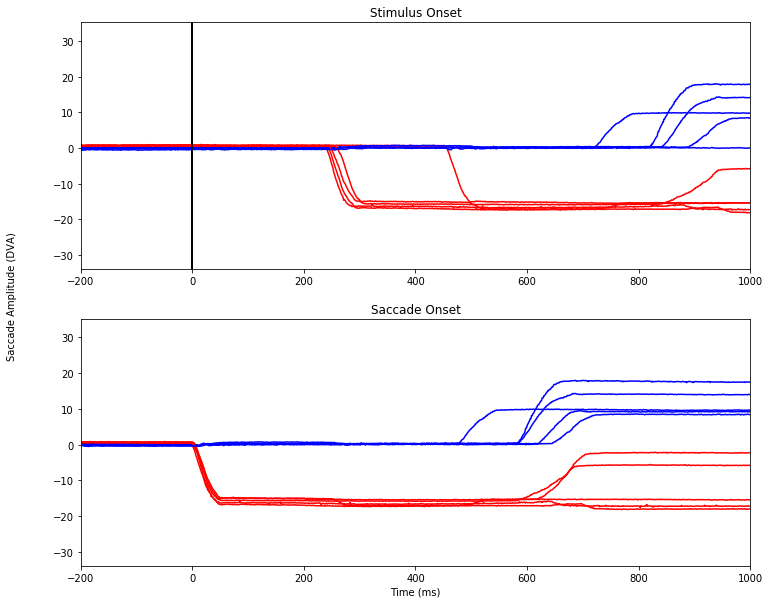

In [21]:
merged_bothAlign = af.add_saccade_onsets( mergedDS, 'bhv_code40', 'bhv_code666' )
stimOn_eyealign = af.alignments4trials( merged_bothAlign, 'bhv_code40', 'saccade_onset', 0 )
plt.show( stimOn_eyealign )

In [22]:
merged_bothAlign = af.adjustSpikes_SaccadeStart( merged_bothAlign, 'saccade_onset', 'SPK' )

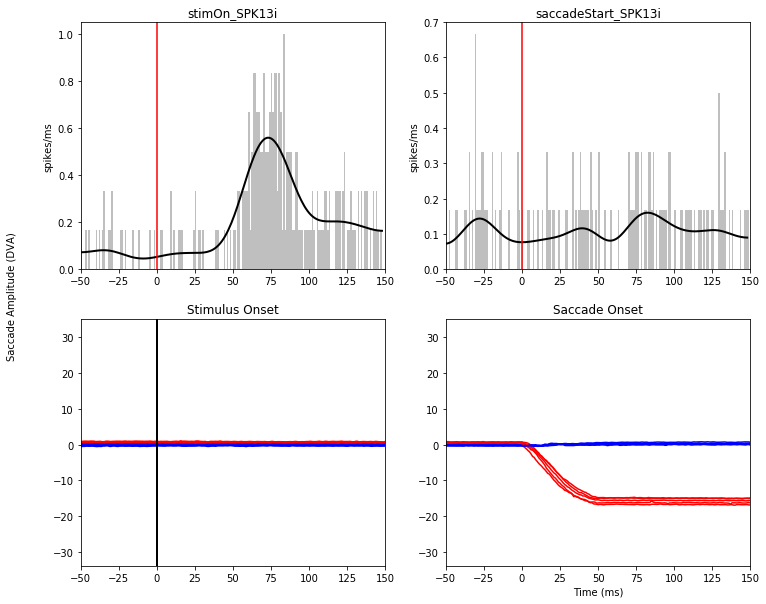

In [23]:
combinedalign = af.eyespike_dualAligned( merged_bothAlign, 'SPK13i', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( combinedalign )

In [24]:
merged_bothAlign = merged_bothAlign.assign( neuralDat = chosen_data, BHVdat = bhv_file )
merged_bothAlign

,index,start,end,SPK01i,SPK02i,SPK03i,SPK04i,SPK05i,SPK06i,SPK07i,...,saccadeStart_SPK09i,saccadeStart_SPK10i,saccadeStart_SPK11i,saccadeStart_SPK12i,saccadeStart_SPK13i,saccadeStart_SPK14i,saccadeStart_SPK15i,saccadeStart_SPK16a,neuralDat,BHVdat
0,0,18.1200,21.1730,[],[],[],[],[],[],[],...,"[-587.2709, -417.2709, -166.2709, 622.2291, 16...","[-583.7709, -535.7709, -443.2709, -318.7709, -...","[-852.2709, -840.2709, -834.2709, -826.2709, -...","[-860.7709, -858.7709, -852.7709, -847.7709, -...","[-857.7709, -845.2709, -841.2709, -809.7709, -...","[-860.2709, -858.7709, -857.2709, -852.7709, -...","[-860.7709, -830.2709, -828.7709, -810.7709, -...","[-828.7709, -743.7709, -688.2709, -542.2709, -...",T35_083018_t1_spikingDAT.mat,180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1...
1,1,30.3440,33.4060,[],[],[],[],[],[],[],...,"[-558.7701, 297.2299, 1097.2299, 1445.7299, 20...","[-344.7701, -318.2701, -281.7701, -187.2701, -...","[-681.7701, -662.7701, -633.2701, -604.2701, -...","[-735.2701, -734.7701, -727.7701, -725.2701, -...","[-712.2701, -689.7701, -684.7701, -678.2701, -...","[-734.7701, -729.7701, -728.2701, -725.7701, -...","[-732.2701, -708.7701, -690.7701, -676.7701, -...","[-717.2701, -680.7701, -630.2701, -522.2701, -...",T35_083018_t1_spikingDAT.mat,180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1...
2,2,40.9360,43.8890,[],[],[],[],[],[],[],...,"[-447.3676, -400.3676, -391.8676, -382.3676, 4...","[-895.3676, -882.8676, -821.3676, -808.8676, -...","[-946.3676, -935.3676, -904.8676, -899.3676, -...","[-946.3676, -934.8676, -931.8676, -928.8676, -...","[-919.3676, -915.8676, -913.8676, -912.8676, -...","[-948.8676, -947.3676, -943.3676, -941.8676, -...","[-944.3676, -941.8676, -928.3676, -926.8676, -...","[-947.3676, -906.3676, -829.8676, -782.8676, -...",T35_083018_t1_spikingDAT.mat,180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1...
3,3,51.6380,54.5915,[],[],[],[],[],[],[],...,"[-428.5943, -192.0943, -186.5943, -169.5943, -...","[-673.0943, -548.5943, -424.5943, -378.5943, -...","[-752.5943, -752.0943, -745.0943, -742.0943, -...","[-751.5943, -749.0943, -747.0943, -745.5943, -...","[-748.0943, -726.5943, -723.5943, -659.5943, -...","[-753.0943, -751.5943, -749.5943, -748.0943, -...","[-752.0943, -751.0943, -739.0943, -729.0943, -...","[-650.5943, -589.5943, -499.5943, -331.5943, -...",T35_083018_t1_spikingDAT.mat,180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1...
4,4,62.3405,65.4025,[],[],[],[],[],[],[],...,"[-152.2307, -26.7307, 75.7693, 173.2693, 540.7...","[-798.7307, -785.2307, -622.7307, -475.7307, -...","[-820.7307, -786.7307, -777.2307, -756.2307, -...","[-846.2307, -845.2307, -840.2307, -839.2307, -...","[-832.2307, -828.2307, -821.2307, -808.7307, -...","[-842.7307, -842.2307, -838.2307, -837.2307, -...","[-837.7307, -824.2307, -821.7307, -819.7307, -...","[-790.7307, -748.2307, -614.2307, -513.7307, -...",T35_083018_t1_spikingDAT.mat,180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1...
5,5,72.9325,75.9945,[],[],[],[],[],[],[],...,"[-561.4904, -518.9904, -383.9904, -368.9904, -...","[-823.9904, -739.4904, -709.9904, -702.9904, -...","[-842.9904, -835.4904, -823.9904, -811.4904, -...","[-846.9904, -844.4904, -843.4904, -841.4904, -...","[-845.4904, -837.9904, -834.9904, -830.4904, -...","[-846.9904, -844.9904, -844.4904, -843.4904, -...","[-844.4904, -843.4904, -840.9904, -838.9904, -...","[-844.4904, -764.9904, -666.4904, -541.4904, -...",T35_083018_t1_spikingDAT.mat,180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1...


In [25]:
merged_bothAlign.to_pickle("T35_083018_t1_delayedSaccade.pkl")

In [29]:
t1 = pd.read_pickle("T35_083018_t1_delayedSaccade.pkl")
t2 = pd.read_pickle("T35_083018_t2_delayedSaccade.pkl")
t3 = pd.read_pickle("T35_083018_t3_delayedSaccade.pkl")

ds_df = pd.concat([t1, t2, t3], ignore_index=True)
ds_df = ds_df.assign( task = 'delayed saccade' )
ds_df.shape

(90, 75)

In [30]:
#ds_df.to_pickle("delayedSaccade.pkl")